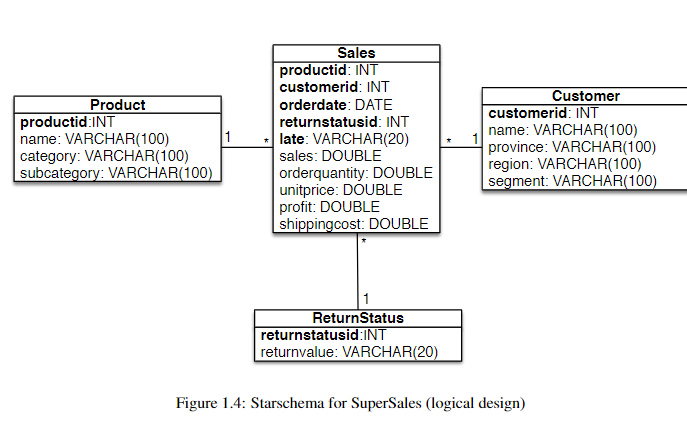

### Step 1: Business questions (given)
For this new warehouse in Canada, Mr. Bezos wants to know answers for the following questions
- Which products/product categories made the most loss?
- Which products/product categories were shipped really late (more than 2 days)?
- Which products/product categories were returned the most?



In [77]:
import zipfile

zip_file_path = "./SuperSales.zip"
extract_to = "./"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping complete!")

Unzipping complete!


In [78]:
import os
import pandas as pd

for file in os.listdir('./SuperSales'):
    print(file)
    
main = pd.read_csv('./SuperSales/SuperstoreSales_main.csv',sep=';',encoding="ISO-8859-1")
manager = pd.read_csv('./SuperSales/SuperstoreSales_manager.csv',sep=';',encoding="ISO-8859-1")
returns = pd.read_csv('./SuperSales/SuperstoreSales_returns.csv',sep=';',encoding="ISO-8859-1")

SuperstoreSales_main.csv
SuperstoreSales_manager.csv
SuperstoreSales_returns.csv


In [79]:
print("main:",main.columns)
print("manager:",manager.columns)
print("ret:",returns.columns)

main: Index(['Row ID', 'Order ID', 'Order Date', 'Order Priority', 'Order Quantity',
       'Sales', 'Discount', 'Ship Mode', 'Profit', 'Unit Price',
       'Shipping Cost', 'Customer Name', 'Province', 'Region',
       'Customer Segment', 'Product Category', 'Product Sub-Category',
       'Product Name', 'Product Container', 'Product Base Margin',
       'Ship Date'],
      dtype='object')
manager: Index(['Region', 'Manager'], dtype='object')
ret: Index(['Order ID', 'Status'], dtype='object')


In [80]:
# top 5 loss
## Profit = Sales - (Cost + Discounts + Shipping, etc.)
main_returned = pd.merge(returns,main,how='left',on='Order ID')

### replacing to float
main_returned['Profit'] = main_returned.Profit.astype(str).str.replace(',','.').astype(float)
top5_loss_products = main_returned.groupby('Product Name')['Profit'].sum().sort_values(ascending=True)[0:5]
top5_loss_products_cat = main_returned.groupby('Product Category')['Profit'].sum().sort_values(ascending=True)[0:5]
print(f"""Top 5 Products that made the most loss: \n {top5_loss_products},
      \n ----------------------------- \n 
      Top 5 Products Categories that made the most loss: \n {top5_loss_products_cat}""")

Top 5 Products that made the most loss: 
 Product Name
Polycom ViewStationª ISDN Videoconferencing Unit                -11984.40
Riverside Palais Royal Lawyers Bookcase, Royale Cherry Finish   -11053.60
Polycom ViewStationª Adapter H323 Videoconferencing Unit         -4858.67
Hon iLevelª Computer Training Table                              -4283.90
Bush Mission Pointe Library                                      -3837.46
Name: Profit, dtype: float64,
      
 ----------------------------- 
 
      Top 5 Products Categories that made the most loss: 
 Product Category
Furniture           -3487.53
Office Supplies    100921.47
Technology         100998.96
Name: Profit, dtype: float64


In [81]:
def convert_two_digit_year(date_str):
    # Convert two-digit years (e.g., '10' -> '2010')
    parts = date_str.split('/')
    if len(parts[2]) == 2:
        parts[2] = '20' + parts[2]  # Assumes years in the 2000s
    return '/'.join(parts)

main['Order Date'] = main['Order Date'].apply(convert_two_digit_year)
main['Ship Date'] = main['Ship Date'].apply(convert_two_digit_year)

# Now convert to datetime
main['Order Date'] = pd.to_datetime(main['Order Date'], format='%d/%m/%Y')
main['Ship Date'] = pd.to_datetime(main['Ship Date'], format='%d/%m/%Y')

# Calculate Delivery Days
main['Delivery Days'] = (main['Ship Date'] - main['Order Date']).dt.days

main['Order Date'] = pd.to_datetime(main['Order Date'], format='%d/%m/%Y', errors='coerce')
main['Ship Date'] = pd.to_datetime(main['Ship Date'], format='%d/%m/%Y', errors='coerce')

# If needed, you can check if there are any invalid dates:
invalid_orders = main[main['Order Date'].isna()]
invalid_ships = main[main['Ship Date'].isna()]

main['Order Date'] = pd.to_datetime(main['Order Date'], infer_datetime_format=True, errors='coerce')
main['Ship Date'] = pd.to_datetime(main['Ship Date'], infer_datetime_format=True, errors='coerce')

# Calculate Delivery Days
main['Delivery Days'] = (main['Ship Date'] - main['Order Date']).dt.days


C:\Users\Mardeen\AppData\Local\Temp\ipykernel_9288\3059251151.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  main['Order Date'] = pd.to_datetime(main['Order Date'], infer_datetime_format=True, errors='coerce')
C:\Users\Mardeen\AppData\Local\Temp\ipykernel_9288\3059251151.py:26: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  main['Ship Date'] = pd.to_datetime(main['Ship Date'], infer_datetime_format=True, errors='coerce')


In [82]:
# Filter only late shipments (Delivery Days > 2)
late_shipments = main[main['Delivery Days'] > 2]
# Count occurrences of late shipments per product
top5_late_products = late_shipments.groupby('Product Name').size().sort_values(ascending=False).head(5)
# Count occurrences of late shipments per product category
top5_late_products_cat = late_shipments.groupby('Product Category').size().sort_values(ascending=False).head(5)
print(f"""Top 5 Products that were shipped really late (more than 2 days): \n {top5_late_products},
      \n ----------------------------- \n 
      Top 5 Product Categories that were shipped really late (more than 2 days): \n {top5_late_products_cat}""")


Top 5 Products that were shipped really late (more than 2 days): 
 Product Name
Global Deluxe Stacking Chair, Gray                   7
Microsoft Internet Keyboard                          6
Global High-Back Leather Tilter, Burgundy            6
Bush Advantage Collection¨ Round Conference Table    6
Avery 506                                            6
dtype: int64,
      
 ----------------------------- 
 
      Top 5 Product Categories that were shipped really late (more than 2 days): 
 Product Category
Office Supplies    840
Technology         375
Furniture          318
dtype: int64


In [97]:
top5_returned_products = main_returned.groupby('Product Name').size().sort_values(ascending=False).head(5)
top5_returned_products_cat = main_returned.groupby('Product Category').size().sort_values(ascending=False).head(5)
print(f"""Top 5 Products that were most returned: \n {top5_returned_products},
      \n ----------------------------- \n 
      Top 5 Products Categories that were most returned: \n {top5_returned_products_cat}""")

Top 5 Products that were most returned: 
 Product Name
O'Sullivan Elevations Bookcase, Cherry Finish      5
Bush Mission Pointe Library                        5
Imation Neon Mac Format Diskettes, 10/Pack         5
Coloredge Poster Frame                             5
Riverside Furniture Stanwyck Manor Table Series    5
dtype: int64,
      
 ----------------------------- 
 
      Top 5 Products Categories that were most returned: 
 Product Category
Office Supplies    461
Technology         218
Furniture          193
dtype: int64


### Step 2: Multidimensional model (given)

##### ReturnStatus Table (Normalized Approach)

In [98]:
import psycopg2
from sqlalchemy import create_engine 

DB_HOST = "bronto.ewi.utwente.nl"
DB_NAME = "dab_ds2425-2a_10"  
DB_USER = "dab_ds2425-2a_10"       
DB_PASS = "FYeq6/bll9ZFREsS"       
DB_PORT = "5432"                # Default PostgreSQL port
engine = create_engine(f'postgresql://{DB_NAME}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

CREATE_TABLES_SQL = """
    CREATE SCHEMA IF NOT EXISTS ass3;

    CREATE TABLE IF NOT EXISTS ass3.product (
        productId INT PRIMARY KEY,
        name VARCHAR(100),
        category VARCHAR(100),
        subcategory VARCHAR(100)
    );

    CREATE TABLE IF NOT EXISTS ass3.customer (
        customerId INT PRIMARY KEY,
        name VARCHAR(100),
        province VARCHAR(100),
        region VARCHAR(100),
        segment VARCHAR(100)
    );

    CREATE TABLE IF NOT EXISTS ass3.returnstatus (
        returnstatusId INT PRIMARY KEY,
        returnvalue VARCHAR(20)
    );

    CREATE TABLE IF NOT EXISTS ass3.sales (
        productId INT,
        customerId INT,
        orderdate DATE,
        returnstatusId INT,
        late VARCHAR(20) CHECK (late IN ('Late', 'NotLate')),
        sales DOUBLE PRECISION,
        orderquantity DOUBLE PRECISION,
        unitprice DOUBLE PRECISION,
        profit DOUBLE PRECISION,
        shippingcost DOUBLE PRECISION,
        FOREIGN KEY (productId) REFERENCES ass3.product(productId),
        FOREIGN KEY (customerId) REFERENCES ass3.customer(customerId),
        FOREIGN KEY (returnstatusId) REFERENCES ass3.returnstatus(returnstatusId)
    );
"""

try:
    conn = psycopg2.connect(
        dbname=DB_NAME, user=DB_USER, password=DB_PASS, host=DB_HOST, port=DB_PORT
    )
    conn.autocommit = True  
    cursor = conn.cursor()
    cursor.execute(CREATE_TABLES_SQL)
    print("Tables created successfully.")
    cursor.close()
    conn.close()
except Exception as e:
    print("Error:", e)


Tables created successfully.


### Step 3: Data exploration: Excel

### Step 4: ETL — Prepare data and fill the database

##### Grouping and Aggregating the data

In [99]:
print("main:",main.columns)
print("manager:",manager.columns)
print("ret:",returns.columns)

##Return Status
return_status = pd.DataFrame({
    'returnstatusid': [0, 1],
    'returnvalue': ['NotReturned', 'Returned']
})

return_status.to_sql('returnstatus', engine, schema='ass3', if_exists='replace', index=False)

## Product
product_df = main[['Product Name', 'Product Category', 'Product Sub-Category']].drop_duplicates().reset_index(drop=True)
product_df['productId'] = product_df.index
product_df = product_df.rename(columns={
    'Product Name': 'name',
    'Product Category': 'category',
    'Product Sub-Category': 'subcategory'
})
product_df.to_sql('product', engine, schema='ass3', if_exists='replace', index=False)

## Customer
customer_df = main[['Customer Name', 'Province', 'Region', 'Customer Segment']].drop_duplicates().reset_index(drop=True)
customer_df['customerId'] = customer_df.index
customer_df = customer_df.rename(columns={
    'Customer Name': 'name',
    'Customer Segment': 'segment'
})
customer_df.to_sql('customer', engine, schema='ass3', if_exists='replace', index=False)

main: Index(['Row ID', 'Order ID', 'Order Date', 'Order Priority', 'Order Quantity',
       'Sales', 'Discount', 'Ship Mode', 'Profit', 'Unit Price',
       'Shipping Cost', 'Customer Name', 'Province', 'Region',
       'Customer Segment', 'Product Category', 'Product Sub-Category',
       'Product Name', 'Product Container', 'Product Base Margin', 'Ship Date',
       'Delivery Days'],
      dtype='object')
manager: Index(['Region', 'Manager'], dtype='object')
ret: Index(['Order ID', 'Status'], dtype='object')


832

In [100]:
# Merge main and return table for sales
main_merged = main.merge(returns, on='Order ID', how='left')  # ret contains 'Order ID', 'Status'
main_merged['Status'] = main_merged['Status'].fillna('NotReturned')  # fill missing returns
main_merged['returnstatusId'] = main_merged['Status'].map({'NotReturned': 0, 'Returned': 1})

In [ ]:
# Add "Late" column (inlined dimension)
main_merged['late'] = main_merged['Delivery Days'].apply(lambda x: 'Late' if x > 2 else 'NotLate')

# Map productId and customerId from earlier dataframes
main_merged = main_merged.merge(product_df[['productId', 'name']], left_on='Product Name', right_on='name')
main_merged = main_merged.merge(customer_df[['customerId', 'name']], left_on='Customer Name', right_on='name', suffixes=('_prod', '_cust'))

# Prepare Sales fact table
sales_df = main_merged[[
    'productId', 'customerId', 'Order Date', 'returnstatusId', 'late',
    'Sales', 'Order Quantity', 'Unit Price', 'Profit', 'Shipping Cost'
]].rename(columns={
    'Order Date': 'orderdate',
    'Sales': 'sales',
    'Order Quantity': 'orderquantity',
    'Unit Price': 'unitprice',
    'Profit': 'profit',
    'Shipping Cost': 'shippingcost'
})

# Convert date column
sales_df['orderdate'] = pd.to_datetime(sales_df['orderdate'])

# Write to sales table
#sales_df.to_sql('sales', engine, schema='ass3', if_exists='replace', index=False)
#print("Data loaded into PostgreSQL successfully.")

In [102]:
cols_to_convert1 = ['sales','unitprice','profit','shippingcost']
for col in cols_to_convert1:
    sales_df[col] = sales_df[col].str.replace(',', '.', regex=False)  # replace comma with dot


In [103]:
# Group and aggregate
# Convert numeric columns (in case they were read as strings)
cols_to_convert = ['sales', 'orderquantity', 'unitprice', 'profit', 'shippingcost']
for col in cols_to_convert:
    sales_df[col] = pd.to_numeric(sales_df[col], errors='coerce')  # invalid strings will become NaN

sales_grouped = sales_df.groupby(
    ['productId', 'customerId', 'orderdate', 'late', 'returnstatusId'],
    as_index=False
).agg({
    'sales': 'sum',
    'orderquantity': 'sum',
    'unitprice': 'mean',         # or first(), if it's always the same per group
    'profit': 'sum',
    'shippingcost': 'sum'
})

# Optional: round values
sales_grouped['unitprice'] = sales_grouped['unitprice'].round(2)

sales_grouped
# Load into the database
sales_grouped.to_sql('sales', engine, schema='ass3', if_exists='replace', index=False)


353

### Step 4: Visualization

In [104]:
## See tables 
from sqlalchemy import text
with engine.connect() as conn:
    result = conn.execute(text("""SELECT table_name 
                          FROM information_schema.tables
                          WHERE table_schema='ass3'"""))
    print(result.fetchall())

pd.read_sql_table('product', engine,schema='ass3').info()
pd.read_sql_table('customer', engine,schema='ass3').info()
pd.read_sql_table('sales', engine,schema='ass3').info()
pd.read_sql_table('returnstatus', engine,schema='ass3').info()

[('sales',), ('returnstatus',), ('product',), ('customer',)]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         1263 non-null   object
 1   category     1263 non-null   object
 2   subcategory  1263 non-null   object
 3   productId    1263 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 39.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1832 entries, 0 to 1831
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        1832 non-null   object
 1   Province    1832 non-null   object
 2   Region      1832 non-null   object
 3   segment     1832 non-null   object
 4   customerId  1832 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 71.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23353 entries, 0 to 23352
Data columns (total 10 

### Which products/product categories were shipped really late (more than 2 days)?

In [108]:
from sqlalchemy import text

query = text("""
    SELECT p."name" AS product_name, 
           p."category" AS product_category,
           s."shippingcost",
           s."orderdate",
           s."customerId"
    FROM ass3.sales s
    JOIN ass3.product p ON s."productId" = p."productId"
    WHERE s."late" = 'Late'
""")

with engine.connect() as conn:
    df_late_products = pd.read_sql_query(query, conn)

df_late_products.head()


,product_name,product_category,shippingcost,orderdate,customerId
0,"Eldon Base for stackable storage shelf, platinum",Office Supplies,35.00,2010-10-13,0
1,"Eldon Base for stackable storage shelf, platinum",Office Supplies,35.00,2010-10-13,64
2,"Eldon Base for stackable storage shelf, platinum",Office Supplies,35.00,2010-10-13,118
3,"Cardinal Slant-D¨ Ring Binder, Heavy Gauge Vinyl",Office Supplies,2.99,2010-08-04,507
4,"Cardinal Slant-D¨ Ring Binder, Heavy Gauge Vinyl",Office Supplies,2.99,2012-11-11,635


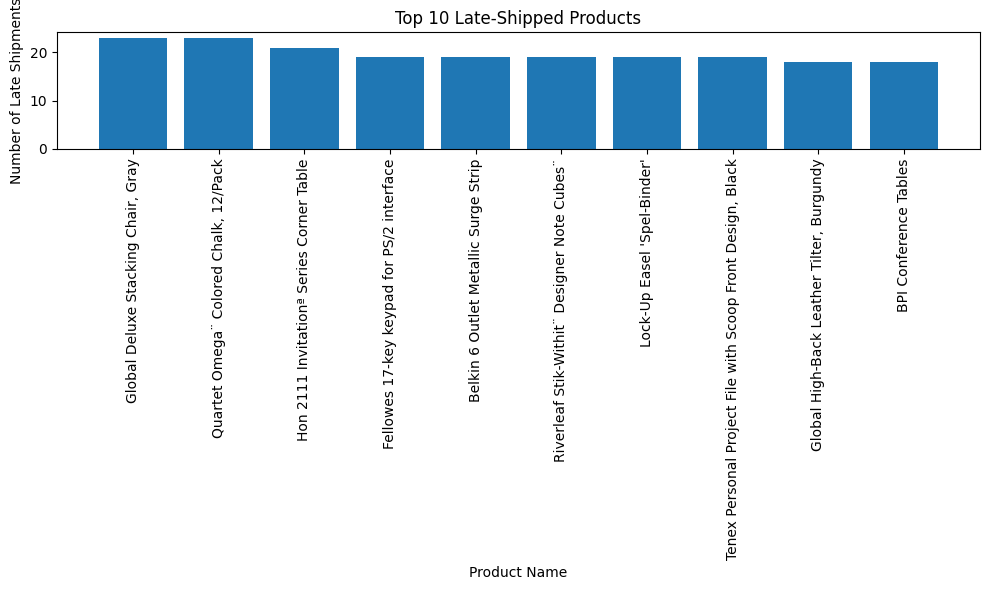

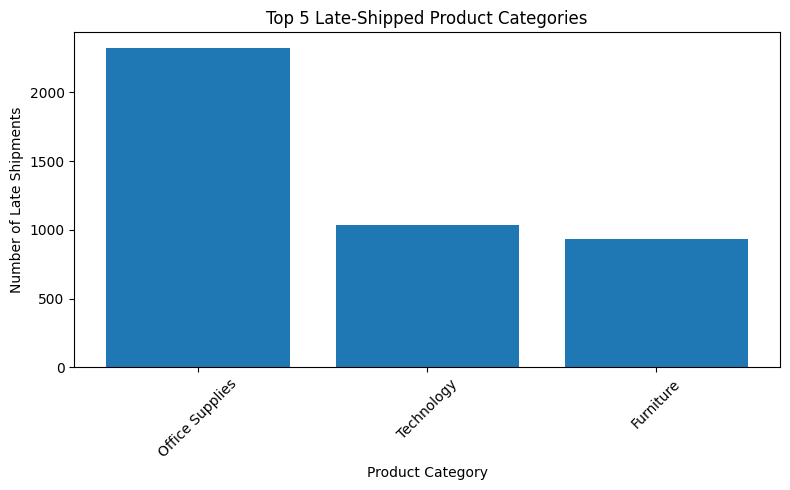

In [110]:
import matplotlib.pyplot as plt

# 1. Top 10 late products by count
top_late_products = df_late_products['product_name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_late_products.index, top_late_products.values)
plt.xlabel('Product Name')
plt.ylabel('Number of Late Shipments')
plt.title('Top 10 Late-Shipped Products')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2. Top 5 product categories by count
top_late_categories = df_late_products['product_category'].value_counts().head(5)

plt.figure(figsize=(8, 5))
plt.bar(top_late_categories.index, top_late_categories.values)
plt.xlabel('Product Category')
plt.ylabel('Number of Late Shipments')
plt.title('Top 5 Late-Shipped Product Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
